In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense
from tensorflow.keras.optimizers import Adam


In [2]:
df = pd.read_csv('well_data.csv', index_col=0)
print(df)

        CHK       PWH       PDC       TWH      FGAS      FOIL       QTOT
0     0.540  0.542755  0.211586  0.594760  0.138882  0.861118  32.358228
1     0.540  0.542755  0.211586  0.594760  0.142222  0.857774  32.940225
2     0.894  0.458000  0.222654  0.616555  0.144697  0.855303  48.633042
3     0.894  0.452311  0.222556  0.609029  0.144938  0.855056  48.065657
4     0.894  0.443485  0.221839  0.602488  0.144187  0.855807  47.096656
...     ...       ...       ...       ...       ...       ...        ...
3094  0.534  0.462606  0.215561  0.592627  0.128039  0.826061  28.108285
3095  0.534  0.462854  0.216331  0.589506  0.127935  0.825378  28.119254
3096  0.534  0.463855  0.239411  0.594895  0.127857  0.824711  27.875849
3097  0.415  0.498174  0.234317  0.581882  0.129256  0.833875  18.412828
3098  0.541  0.463279  0.216901  0.592885  0.127476  0.822423  28.678289

[3099 rows x 7 columns]


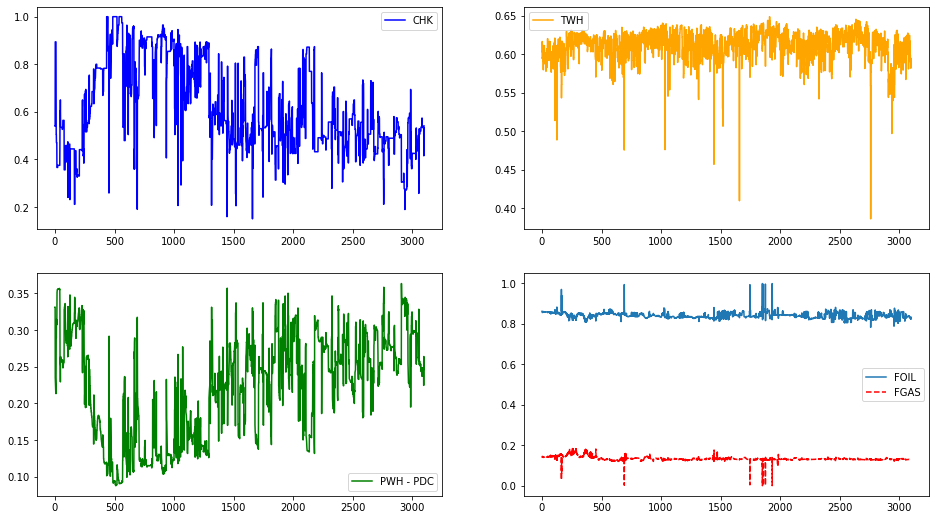

In [3]:
fig, ax = plt.subplots(2, 2, figsize=(16, 9))

# Choke valve opening
ax[0, 0].plot(df['CHK'], label='CHK', color="blue")
ax[0, 0].legend()

# Total floqw through choke valve
ax[0, 1].plot(df['TWH'], label='TWH', color='orange')
ax[0, 1].legend()

# Diff pressure over choke valve
ax[1, 0].plot(df['PWH'] - df['PDC'], label='PWH - PDC', color='green')
ax[1, 0].legend()

# Fractions
ax[1, 1].plot(df['FOIL'], label='FOIL')
ax[1, 1].plot(df['FGAS'], '--r', label='FGAS')
ax[1, 1].legend()

In [4]:
df.corr()

,CHK,PWH,PDC,TWH,FGAS,FOIL,QTOT
CHK,1.000000,-0.963694,0.706279,0.285622,0.091705,-0.087384,0.935945
PWH,-0.963694,1.000000,-0.690669,-0.262040,-0.053365,0.097010,-0.889464
PDC,0.706279,-0.690669,1.000000,0.086445,-0.071751,-0.103538,0.647044
TWH,0.285622,-0.262040,0.086445,1.000000,0.070121,-0.096992,0.372099
FGAS,0.091705,-0.053365,-0.071751,0.070121,1.000000,-0.375864,0.189640
FOIL,-0.087384,0.097010,-0.103538,-0.096992,-0.375864,1.000000,-0.096468
QTOT,0.935945,-0.889464,0.647044,0.372099,0.189640,-0.096468,1.000000


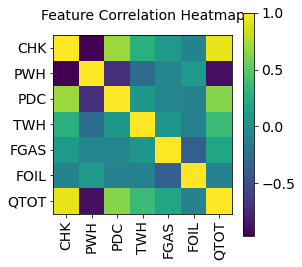

In [5]:
def show_heatmap(data):
    plt.matshow(data.corr())
    plt.xticks(range(data.shape[1]), data.columns, fontsize=14, rotation=90)
    plt.gca().xaxis.tick_bottom()
    plt.yticks(range(data.shape[1]), data.columns, fontsize=14)

    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title("Feature Correlation Heatmap", fontsize=14)
    plt.show()


show_heatmap(df)

# Split into training and test data



In [6]:
test_set = df.iloc[2000:2500]




x_test = test_set.drop(columns='QTOT')
y_test = test_set[['QTOT']]

#train_val_set = df.copy().drop(test_set.index) 
train_val_set = df.iloc[0:500]

#from sklearn.utils import shuffle
#x_train, y_train = shuffle(x_train, y_train)


In [7]:


val_set = train_val_set.sample(frac=0.1, replace=False)
train_set = train_val_set.copy().drop(val_set.index)


n_points = len(train_set) + len(val_set) + len(test_set)
print(f'{len(df)} = {len(train_set)} + {len(val_set)} + {len(test_set)} = {n_points}')


x_val = val_set.drop(columns='QTOT')
y_val = val_set[['QTOT']]


x_train = train_set.drop(columns='QTOT')
y_train = train_set[['QTOT']]


3099 = 450 + 50 + 500 = 1000


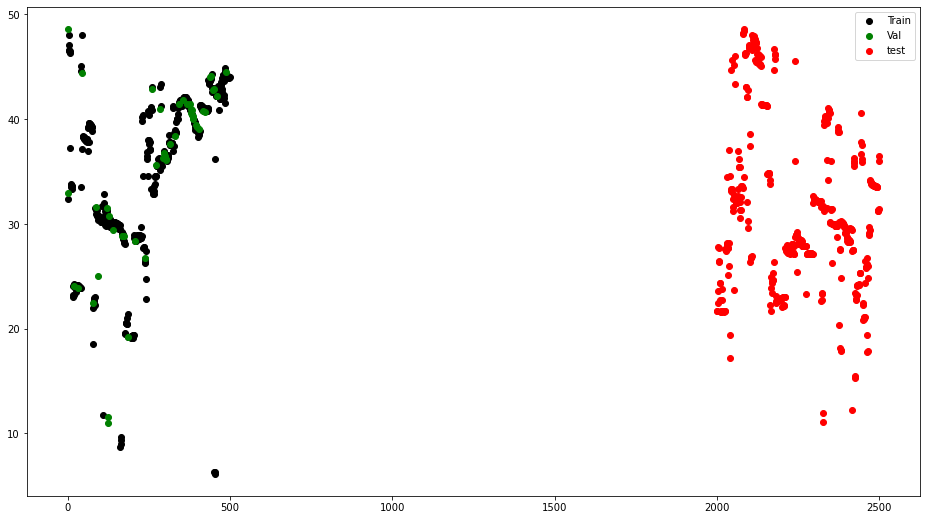

In [8]:
plt.figure(figsize=(16,9))
plt.scatter(y_train.index, y_train.values, color='black', label='Train')
plt.scatter(val_set.index, val_set['QTOT'], color='green', label='Val')
plt.scatter(y_test.index, y_test.values, color='red', label='test')
plt.legend()

# Keras Model

In [9]:
from keras import regularizers
from keras.layers import Dropout

input_layer_size = x_train.columns.size

model = keras.Sequential()

model.add(keras.layers.Dense(input_layer_size, activation='relu', input_shape=(input_layer_size,)))
model.add(keras.layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(keras.layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(keras.layers.Dropout(0.1))
model.add(keras.layers.Dense(1))

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 6)                 42        
_________________________________________________________________
dense_1 (Dense)              (None, 32)                224       
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 1,355
Trainable params: 1,355
Non-trainable params: 0
_________________________________________________________________


In [11]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

In [12]:

from keras.callbacks import EarlyStopping

callback = EarlyStopping(monitor='val_loss', patience=4)


history = model.fit(x_train,y_train,validation_data=(x_val, y_val),epochs=100, batch_size=10, callbacks=[callback],verbose=2)

Epoch 1/100
45/45 - 0s - loss: 1239.7244 - val_loss: 1321.0258
Epoch 2/100
45/45 - 0s - loss: 1210.0291 - val_loss: 1275.0457
Epoch 3/100
45/45 - 0s - loss: 1139.9243 - val_loss: 1166.6672
Epoch 4/100
45/45 - 0s - loss: 981.2449 - val_loss: 942.1552
Epoch 5/100
45/45 - 0s - loss: 716.2408 - val_loss: 607.9305
Epoch 6/100
45/45 - 0s - loss: 391.3724 - val_loss: 259.1735
Epoch 7/100
45/45 - 0s - loss: 154.7923 - val_loss: 83.9111
Epoch 8/100
45/45 - 0s - loss: 97.6858 - val_loss: 60.2002
Epoch 9/100
45/45 - 0s - loss: 94.4035 - val_loss: 58.0660
Epoch 10/100
45/45 - 0s - loss: 86.6830 - val_loss: 58.1034
Epoch 11/100
45/45 - 0s - loss: 88.9491 - val_loss: 58.1364
Epoch 12/100
45/45 - 0s - loss: 98.7033 - val_loss: 56.1319
Epoch 13/100
45/45 - 0s - loss: 93.9423 - val_loss: 59.3216
Epoch 14/100
45/45 - 0s - loss: 83.7847 - val_loss: 56.1411
Epoch 15/100
45/45 - 0s - loss: 82.7343 - val_loss: 55.0360
Epoch 16/100
45/45 - 0s - loss: 93.1013 - val_loss: 55.9309
Epoch 17/100
45/45 - 0s - loss

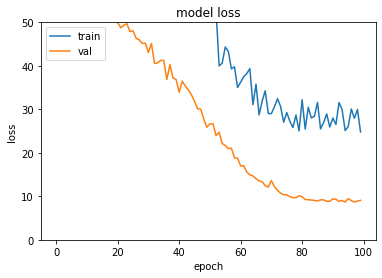

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
axes = plt.gca()
axes.set_ylim([0,50])
plt.show()

In [14]:
keras_predictions = model.predict(x_test, verbose=2)

16/16 - 0s


In [15]:


print("Error on test data")
mse_test = np.mean(np.power(keras_predictions - y_test.values, 2))
print("MSE: ", mse_test) #2.6873526

mae_test = np.mean(np.abs(keras_predictions-y_test.values))
print("MAE: ", mae_test) # 1.12

mape_test = 100*np.mean(np.abs(np.divide(keras_predictions - y_test.values, y_test.values)))
print("MAPE: ", mape_test, "%") # 3.574



Error on test data
MSE:  10.840549980289328
MAE:  2.642200270943066
MAPE:  9.745287804084771 %


# Pytorch model

In [16]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch.utils.data import DataLoader
from math import sqrt

%matplotlib inline

class Net(torch.nn.Module):
    """
    PyTorch offers several ways to construct neural networks.
    Here we choose to implement the network as a Module class.
    This gives us full control over the construction and clarifies our intentions.
    """
    
    def __init__(self, layers):
        """
        Constructor of neural network
        :param layers: list of layer widths. Note that len(layers) = network depth + 1 since we incl. the input layer.
        """
        super().__init__()

        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'

        assert len(layers) >= 2, "At least two layers are required (incl. input and output layer)"
        self.layers = layers

        # Fully connected linear layers
        linear_layers = []

        for i in range(len(self.layers) - 1):
            n_in = self.layers[i]
            n_out = self.layers[i+1]
            layer = torch.nn.Linear(n_in, n_out)

            # Initialize weights and biases
            a = 1 if i == 0 else 2
            layer.weight.data = torch.randn((n_out, n_in)) * sqrt(a / n_in)
            layer.bias.data = torch.zeros(n_out)
            
            # Add to list
            linear_layers.append(layer)
        
        # Modules/layers must be registered to enable saving of model
        self.linear_layers = torch.nn.ModuleList(linear_layers)  

        # Non-linearity (e.g. ReLU, ELU, or SELU)
        self.act = torch.nn.ReLU(inplace=False)

    def forward(self, input):
        """
        Forward pass to evaluate network for input values
        :param input: tensor assumed to be of size (batch_size, n_inputs)
        :return: output tensor
        """
        x = input
        for l in self.linear_layers[:-1]:
            x = l(x)
            x = self.act(x)

        output_layer = self.linear_layers[-1]
        return output_layer(x)

    def get_num_parameters(self):
        return sum(p.numel() for p in self.parameters())

    def save(self, path: str):
        """
        Save model state
        :param path: Path to save model state
        :return: None
        """
        torch.save({
            'model_state_dict': self.state_dict(),
        }, path)

    def load(self, path: str):
        """
        Load model state from file
        :param path: Path to saved model state
        :return: None
        """
        checkpoint = torch.load(path, map_location=torch.device("cuda" if torch.cuda.is_available() else "cpu"))
        self.load_state_dict(checkpoint['model_state_dict'])


In [17]:
def train(
        net: torch.nn.Module,
        train_loader: DataLoader,
        val_loader: DataLoader,
        n_epochs: int,
        lr: float,
        l2_reg: float,
) -> torch.nn.Module:
    """
    Train model using mini-batch SGD
    After each epoch, we evaluate the model on validation data

    :param net: initialized neural network
    :param train_loader: DataLoader containing training set
    :param n_epochs: number of epochs to train
    :param lr: learning rate (default: 0.001)
    :param l2_reg: L2 regularization factor (default: 0)
    :return: torch.nn.Module: trained model.
    """

    # Define loss and optimizer
    criterion = torch.nn.MSELoss(reduction='mean')
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)

    # Train Network
    for epoch in range(n_epochs):
        for inputs, labels in train_loader:
            # Zero the parameter gradients (from last iteration)
            optimizer.zero_grad()

            # Forward propagation
            outputs = net(inputs)
            
            # Compute cost function
            batch_mse = criterion(outputs, labels)
            
            reg_loss = 0
            for param in net.parameters():
                reg_loss += param.pow(2).sum()

            cost = batch_mse + l2_reg * reg_loss

            # Backward propagation to compute gradient
            cost.backward()
            
            # Update parameters using gradient
            optimizer.step()
        
        # Evaluate model on validation data
        mse_val = 0
        for inputs, labels in val_loader:
            mse_val += torch.sum(torch.pow(labels - net(inputs), 2)).item()
        mse_val /= len(val_loader.dataset)
        print(f'Epoch: {epoch + 1}: Val MSE: {mse_val}')
        
    return net


In [18]:
# Define the target and features
INPUT_COLS = ['CHK', 'PWH', 'PDC', 'TWH', 'FGAS', 'FOIL']
OUTPUT_COLS = ['QTOT']

# Get input and output tensors and convert them to torch tensors
x_train = torch.from_numpy(train_set[INPUT_COLS].values).to(torch.float)
y_train = torch.from_numpy(train_set[OUTPUT_COLS].values).to(torch.float)

x_val = torch.from_numpy(val_set[INPUT_COLS].values).to(torch.float)
y_val = torch.from_numpy(val_set[OUTPUT_COLS].values).to(torch.float)

# Create dataset loaders
# Here we specify the batch size and if the data should be shuffled
train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=10, shuffle=True)

val_dataset = torch.utils.data.TensorDataset(x_val, y_val)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=len(val_set), shuffle=False)


In [19]:
layers = [len(INPUT_COLS), 50, 50, len(OUTPUT_COLS)]
net = Net(layers)

print(f'Layers: {layers}')
print(f'Number of model parameters: {net.get_num_parameters()}')
# print(6*50 + 50 + 50*50 + 50 + 50 * 1 + 1)


Layers: [6, 50, 50, 1]
Number of model parameters: 2951


C:\Users\asgeirhu\Anaconda3\lib\site-packages\torch\cuda\__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [20]:
n_epochs = 100
lr = 0.001
l2_reg = 0.001  # 10
net = train(net, train_loader, val_loader, n_epochs, lr, l2_reg)


Epoch: 1: Val MSE: 1049.31234375
Epoch: 2: Val MSE: 601.3182421875
Epoch: 3: Val MSE: 120.800888671875
Epoch: 4: Val MSE: 30.7730810546875
Epoch: 5: Val MSE: 29.40797607421875
Epoch: 6: Val MSE: 26.5060302734375
Epoch: 7: Val MSE: 24.1687255859375
Epoch: 8: Val MSE: 21.87522705078125
Epoch: 9: Val MSE: 19.81322509765625
Epoch: 10: Val MSE: 17.773341064453124
Epoch: 11: Val MSE: 15.59409423828125
Epoch: 12: Val MSE: 13.572181396484375
Epoch: 13: Val MSE: 12.10950927734375
Epoch: 14: Val MSE: 11.080360107421875
Epoch: 15: Val MSE: 9.717081298828125
Epoch: 16: Val MSE: 9.044150390625
Epoch: 17: Val MSE: 8.534476928710937
Epoch: 18: Val MSE: 9.81848876953125
Epoch: 19: Val MSE: 8.126638793945313
Epoch: 20: Val MSE: 7.491729125976563
Epoch: 21: Val MSE: 7.126773071289063
Epoch: 22: Val MSE: 6.526918334960937
Epoch: 23: Val MSE: 6.315571899414063
Epoch: 24: Val MSE: 5.9340625
Epoch: 25: Val MSE: 5.370866088867188
Epoch: 26: Val MSE: 5.229598388671875
Epoch: 27: Val MSE: 5.030570983886719
Epo

In [21]:
# Predict on validation data
pred_val = net(x_val)

# Compute MSE, MAE and MAPE on validation data
print('Error on validation data')

mse_val = torch.mean(torch.pow(pred_val - y_val, 2))
print(f'MSE: {mse_val.item()}')

mae_val = torch.mean(torch.abs(pred_val - y_val))
print(f'MAE: {mae_val.item()}')

mape_val = 100*torch.mean(torch.abs(torch.div(pred_val - y_val, y_val)))
print(f'MAPE: {mape_val.item()} %')


Error on validation data
MSE: 2.6622302532196045
MAE: 1.069650411605835
MAPE: 3.1692862510681152 %


In [22]:
# Get input and output as torch tensors
x_test = torch.from_numpy(test_set[INPUT_COLS].values).to(torch.float)
y_test = torch.from_numpy(test_set[OUTPUT_COLS].values).to(torch.float)

# Make prediction
pred_test = net(x_test)

# Compute MSE, MAE and MAPE on test data
print('Error on test data')

mse_test = torch.mean(torch.pow(pred_test - y_test, 2))
print(f'MSE: {mse_test.item()}')

mae_test = torch.mean(torch.abs(pred_test - y_test))
print(f'MAE: {mae_test.item()}')

mape_test = 100*torch.mean(torch.abs(torch.div(pred_test - y_test, y_test)))
print(f'MAPE: {mape_test.item()} %')


Error on test data
MSE: 26.73920249938965
MAE: 4.853553771972656
MAPE: 17.442087173461914 %


# Compare

In [23]:
print("Error on test data")
mse_test = np.mean(np.power(keras_predictions - y_test.numpy(), 2))
print("MSE: ", mse_test) #2.6873526

mae_test = np.mean(np.abs(keras_predictions-y_test.numpy()))
print("MAE: ", mae_test) # 1.12

mape_test = 100*np.mean(np.abs(np.divide(keras_predictions - y_test.numpy(), y_test.numpy())))
print("MAPE: ", mape_test, "%") # 3.574





Error on test data
MSE:  10.84055
MAE:  2.6422005
MAPE:  9.745287895202637 %


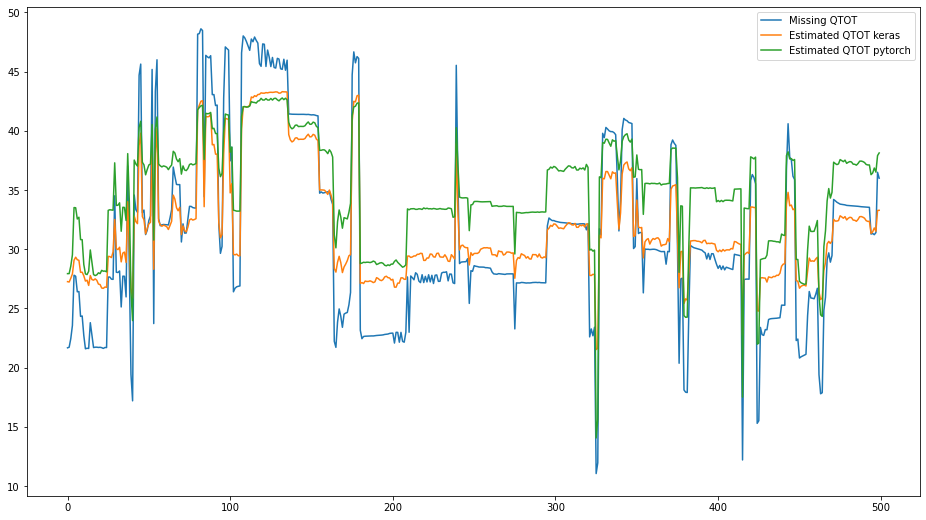

In [24]:
plt.figure(figsize=(16,9))
plt.plot(y_test.numpy(), label='Missing QTOT')
plt.plot(keras_predictions, label='Estimated QTOT keras')
plt.plot(pred_test.detach().numpy(), label='Estimated QTOT pytorch')
plt.legend()